Epoch [1/200] | Train Loss: 0.833259 | Val Loss: 0.642800
Epoch [2/200] | Train Loss: 0.431935 | Val Loss: 0.323683
Epoch [3/200] | Train Loss: 0.295964 | Val Loss: 0.141114
Epoch [4/200] | Train Loss: 0.139455 | Val Loss: 0.096046
Epoch [5/200] | Train Loss: 0.116477 | Val Loss: 0.075487
Epoch [6/200] | Train Loss: 0.107536 | Val Loss: 0.064544
Epoch [7/200] | Train Loss: 0.105038 | Val Loss: 0.059855
Epoch [8/200] | Train Loss: 0.100600 | Val Loss: 0.056902
Epoch [9/200] | Train Loss: 0.095000 | Val Loss: 0.053856
Epoch [10/200] | Train Loss: 0.092272 | Val Loss: 0.050389
Epoch [11/200] | Train Loss: 0.091115 | Val Loss: 0.049417
Epoch [12/200] | Train Loss: 0.089087 | Val Loss: 0.048427
Epoch [13/200] | Train Loss: 0.089399 | Val Loss: 0.048632
Epoch [14/200] | Train Loss: 0.094673 | Val Loss: 0.047739
Epoch [15/200] | Train Loss: 0.088711 | Val Loss: 0.048958
Epoch [16/200] | Train Loss: 0.085012 | Val Loss: 0.048566
Epoch [17/200] | Train Loss: 0.083834 | Val Loss: 0.047394
Epoch 

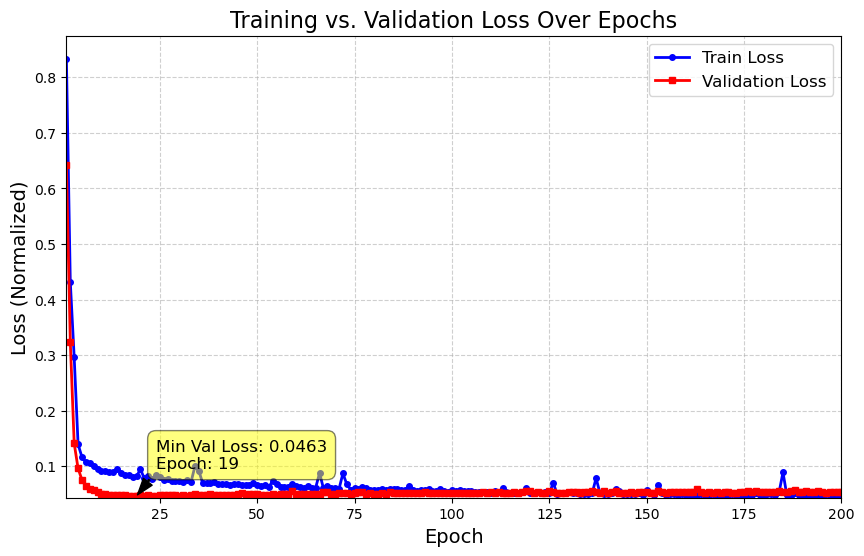

Sample	Predicted MPG	True MPG
--------------------------------------
1	39.27		43.40
54	24.54		28.00
38	15.17		16.00
33	28.45		25.00
36	20.23		20.00
28	28.10		28.10
25	23.24		25.00
23	33.80		33.00
45	35.06		36.10
4	33.01		31.30


In [1]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import requests

# Import MLP components from your mlp.py module.
from mlp import (
    Layer, MultilayerPerceptron,
    SquaredError, CrossEntropy,
    Tanh, Linear, 
    Relu, Softplus, Mish
)

def load_auto_mpg():
    """
    Downloads and processes the Auto MPG dataset from the UCI repository.
    
    Returns:
        X (np.ndarray): Normalized feature array of shape (n_samples, 7)
        y (np.ndarray): Normalized target MPG values of shape (n_samples, 1)
        y_mean (np.ndarray): Mean of original y values (for inverse normalization)
        y_std (np.ndarray): Standard deviation of original y values (for inverse normalization)
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    r = requests.get(url)
    if r.status_code != 200:
        raise Exception(f"Failed to download dataset from {url}. Status code: {r.status_code}")
    
    lines = r.text.strip().split('\n')
    x_list = []
    y_list = []
    for line in lines:
        parts = line.split()
        if len(parts) < 8:
            continue
        mpg_str = parts[0]
        # Skip rows with missing horsepower ('?')
        if '?' in parts[3]:
            continue

        try:
            mpg = float(mpg_str)
            # Extract features: cylinders, displacement, horsepower, weight, acceleration, model year, origin
            features = list(map(float, [parts[1], parts[2], parts[3], parts[4], parts[5], parts[6], parts[7]]))
        except ValueError:
            continue

        x_list.append(features)
        y_list.append(mpg)

    # Convert lists to numpy arrays.
    X = np.array(x_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32).reshape(-1, 1)

    # Normalize features: subtract mean and divide by standard deviation.
    X_mean = X.mean(axis=0, keepdims=True)
    X_std  = X.std(axis=0, keepdims=True) + 1e-9  # small constant to prevent division by zero
    X = (X - X_mean) / X_std

    # Normalize targets and store original mean and std for later inverse transformation.
    y_mean = y.mean(axis=0, keepdims=True)
    y_std  = y.std(axis=0, keepdims=True) + 1e-9
    y_norm = (y - y_mean) / y_std

    return X, y_norm, y_mean, y_std

def main():
    # 1) Download and load the dataset.
    X, y, y_mean, y_std = load_auto_mpg()
    n_samples = X.shape[0]

    # 2) Shuffle the dataset and split into 70% training, 15% validation, and 15% testing.
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    train_end = int(0.70 * n_samples)
    val_end   = int(0.85 * n_samples)
    train_x, train_y = X[:train_end], y[:train_end]
    val_x,   val_y   = X[train_end:val_end], y[train_end:val_end]
    test_x,  test_y  = X[val_end:], y[val_end:]

    # 3) Build the MLP for regression.
    # Architecture: 7 input features -> 16 hidden neurons with Tanh activation -> 1 output with Linear activation.
    layers = [
        Layer(fan_in=7, fan_out=16, activation_function=Tanh()),
        Layer(fan_in=16, fan_out=1, activation_function=Linear())
    ]
    mlp = MultilayerPerceptron(layers)

    # 4) Use the SquaredError loss function (MSE).
    loss_func = SquaredError()

    # 5) Define training parameters.
    learning_rate = 1e-3
    batch_size    = 16
    epochs        = 200

    # 6) Train the model while printing training and validation loss at each epoch.
    train_losses, val_losses = mlp.train(
        train_x, train_y,
        val_x,   val_y,
        loss_func=loss_func,
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs
    )

    # 7) Evaluate the model on the test set (disable dropout by setting training=False).
    pred_test = mlp.forward(test_x, training=True)
    test_loss_norm = loss_func.loss(test_y, pred_test)
    print(f"\nTest Loss on Normalized Data (MSE-like): {test_loss_norm:.4f}")

    # 8) Inverse transform predictions and test targets to the original MPG scale.
    pred_test_actual = pred_test * y_std + y_mean
    test_y_actual    = test_y * y_std + y_mean

    # Compute evaluation metrics on actual MPG values.
    errors_squared = [(pred[0] - true[0])**2 for pred, true in zip(pred_test_actual, test_y_actual)]
    mse_manual = sum(errors_squared) / len(errors_squared)

    absolute_errors = [abs(pred[0] - true[0]) for pred, true in zip(pred_test_actual, test_y_actual)]
    mae_manual = sum(absolute_errors) / len(absolute_errors)

    print("\nEvaluation Metrics (Actual MPG):")
    print(f"Mean Squared Error (MSE): {mse_manual:.4f}")
    print(f"Mean Absolute Error (MAE): {mae_manual:.4f}\n")

    # 9) Plot training and validation loss curves with additional embellishments.
    plt.figure(figsize=(10, 6))
    epochs_range = np.arange(1, epochs + 1)

    # Plot the training loss with circle markers.
    plt.plot(epochs_range, train_losses, marker='o', linestyle='-', color='blue',
            markersize=4, linewidth=2, label='Train Loss')

    # Plot the validation loss with square markers.
    plt.plot(epochs_range, val_losses, marker='s', linestyle='-', color='red',
            markersize=4, linewidth=2, label='Validation Loss')

    # Add labels and title with increased font sizes.
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss (Normalized)', fontsize=14)
    plt.title('Training vs. Validation Loss Over Epochs', fontsize=16)

    # Enable a grid with dashed lines for better readability.
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add a legend with a larger font size.
    plt.legend(fontsize=12)

    # Identify the epoch with the minimum validation loss.
    min_epoch = np.argmin(val_losses) + 1
    min_loss = min(val_losses)

    # Annotate the minimum validation loss on the plot.
    plt.annotate(f'Min Val Loss: {min_loss:.4f}\nEpoch: {min_epoch}',
                xy=(min_epoch, min_loss),
                xytext=(min_epoch + 5, min_loss + 0.05),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                fontsize=12,
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    # Optionally, adjust x and y limits for better visualization.
    plt.xlim(1, epochs)
    plt.ylim(min(min(train_losses), min(val_losses)) * 0.95, max(max(train_losses), max(val_losses)) * 1.05)

    plt.show()


    # 10) Print a table of sample predictions vs. true MPG (denormalized).
    sample_indices = np.random.choice(test_x.shape[0], 10, replace=False)
    print("Sample\tPredicted MPG\tTrue MPG")
    print("--------------------------------------")
    for idx in sample_indices:
        print(f"{idx}\t{pred_test_actual[idx,0]:.2f}\t\t{test_y_actual[idx,0]:.2f}")

if __name__ == "__main__":
    main()
